# BERT ClimaText

In this notebook we will train and evaluate the BERT ClimaText model which will be used for extracting quotes which have to do with climate change.
The dataset used is presented in [[1]](#refs)

Contents:
- [Training the model](#train)
- [Using ClimaTextBERT to extract quotes](#extracteval)
    - [Evaluating the model](#eval)
    - [Extracting Quotes using the model](#extract)



<a id='train'></a>
# Training the model

First we download the training and validation datasets as provided in ClimaText

In [ ]:
!wget "https://www.sustainablefinance.uzh.ch/dam/jcr:c4f6e427-6b84-41ca-a016-e66337fb283b/Wiki-Doc-Train.tsv" -O "WikiDoc.tsv"
!wget "https://www.sustainablefinance.uzh.ch/dam/jcr:43546a2f-82d6-49a3-af54-69b02cff54a9/AL-10Ks.tsv%20:%203000%20(58%20positives,%202942%20negatives)%20(TSV,%20127138%20KB).tsv" -O "AL10Ks.tsv"
!wget "https://www.sustainablefinance.uzh.ch/dam/jcr:9d139a47-878c-4d2c-b9a7-cbb982e284b9/AL-Wiki%20(train).tsv" -O "ALWiki.tsv"

For training the model we will use transformers module from HuggingFact. To be more precise, we will use Distil BERT for Sequence Classification which will be finetuned on the WikiDoc and AL10Ks datasets. <br>
We will import the needed modules


In [ ]:
from sklearn.model_selection import train_test_split
# Load Huggingface transformers
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
import pandas as pd
import torch
import numpy as np

First we load the datasets

In [2]:
wiki_train_data = pd.read_csv("WikiDoc.tsv", sep='\t')
al10ks_train_data = pd.read_csv("AL10Ks.tsv", sep='\t')
alwiki_train_data = pd.read_csv("ALWiki.tsv", sep='\t')

In [3]:
train1 = wiki_train_data
train2 = pd.concat([al10ks_train_data, alwiki_train_data])

The first training set will be the WikiDoc dataset which is made from wikipedia extractions from pages which are classified as related to climate change. <br>
This data set is large containing 115k sentences. However, this dataset has a lot of mistakes because it assumes that a sentence will be related to climate change only due to the fact that it is from an article which might be in some way connected to the topic of climate change. Additionally, this dataset does not contain quotes, but reather scientific statements. 

In [4]:
train1

,id,label,title,paragraph,sentence
0,0,1,Algae,1,Algae (; singular alga ) is an informal term f...
1,1,1,Algae,1,Included organisms range from unicellular micr...
2,2,1,Algae,1,Most are aquatic and autotrophic and lack many...
3,3,1,Algae,1,The largest and most complex marine algae are ...
4,4,1,Algae,2,No definition of algae is generally accepted.
...,...,...,...,...,...
115842,115849,0,Igor Uporov,7,The Ural Siberian Bar Association gathers expe...
115843,115850,0,Roberta Allen,3,"In 2014, the Athenaeum Music & Arts Library in..."
115844,115851,0,Mons,55,The Neo-Egyptian style then became a reference...
115845,115852,0,2005 Roger Federer tennis season,18,Federer arrived in New York and once again fou...


The second training set is related to actual claims/quotes and are much closer to our problem. Moreover, after analyzing the training set we saw that it is also noticably more accurate.

In [5]:
train2

,id,label,title,paragraph,sentence
0,54,0,1000045/1000045_10K_2014.htm,11,• collection of debts from loan customers wh...
1,610,0,1000229/1000229_10K_2014.htm,1,"All known, material risks and uncertainties ar..."
2,708,1,1000229/1000229_10K_2014.htm,25,Although it is not possible at this time to pr...
3,1013,0,1000298/1000298_10K_2014.htm,80,"Ifthere is a decline in real estate values, as..."
4,1084,0,1000694/1000694_10K_2014.htm,3,Our expenses have exceeded ourrevenue since in...
...,...,...,...,...,...
2995,115703,0,DCas9 activation system,2,Cas9 ordinarily has 2 endonuclease domains cal...
2996,115737,0,Qaleh-ye Gomesh Dafeh,1,"Qaleh-ye Gomesh Dafeh (, also Romanized as Qal..."
2997,115808,0,Sabine Hossenfelder,5,"In 2016, Hossenfelder offered to act as a phys..."
2998,115840,0,Debora Green,66,The Debora I knew would not have killed her ch...


Now we seperate the validation set from the training set with a 80/20 ratio

In [6]:
train1, val1 = train_test_split(train1, test_size=.2)
train2, val2 = train_test_split(train2, test_size=.2)

In [7]:
val2

,id,label,title,paragraph,sentence
2588,485571,0,1530950/1530950_10K_2014.htm,60,Avian influenza occasionally affects the domes...
51,1252,0,Coal,17,"In 1700, five-sixths of the world's coal was m..."
2997,115808,0,Sabine Hossenfelder,5,"In 2016, Hossenfelder offered to act as a phys..."
1894,347358,0,1404912/1404912_10K_2014.htm,45,These structures also are subject to potential...
1448,47923,0,Bio-energy with carbon capture and storage,36,Biomass cofiring with coal has efficiency near...
...,...,...,...,...,...
780,26490,0,Tim Flannery,6,"In 2007, Flannery became professor in the Clim..."
1096,190625,0,1217234/1217234_10K_2014.htm,121,We cannot be assured that future cuts would be...
2404,86152,0,Dunces and Dragons,13,The episode was also the highest-rated program...
342,10808,0,Eutrophication,34,"In order for a policy to have any effect, the ..."


Now we load the needed tokenizer and encode the dataset.

In [6]:
# Load tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [9]:
# Tokenize and encode train sets
train1_encodings = tokenizer(list(train1['sentence']), truncation=True, padding=True, max_length=64)
train2_encodings = tokenizer(list(train2['sentence']), truncation=True, padding=True, max_length=64)

In [10]:
# Tokenize and encode validation set
val1_encodings = tokenizer(list(val1['sentence']), truncation=True, padding=True)
val2_encodings = tokenizer(list(val2['sentence']), truncation=True, padding=True)

Load the labels into a list

In [11]:
# Extract labels as a list
train1_labels = list(train1['label'])
train2_labels = list(train2['label'])
val1_labels = list(val1['label'])
val2_labels = list(val2['label'])

Here we construct a pytorch dataset which will be used for training

In [12]:
class ClimaTextDataset(torch.utils.data.Dataset):
    """ Pytorch dataset for training and validation """
    
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [13]:
# Instantiate ClimaTextDatasets
train1_dataset = ClimaTextDataset(train1_encodings, train1_labels)
train2_dataset = ClimaTextDataset(train2_encodings, train2_labels)
val1_dataset = ClimaTextDataset(val1_encodings, val1_labels)
val2_dataset = ClimaTextDataset(val2_encodings, val2_labels)

Now we will load a pre-trained BERT and the accompanying tokenizer. <br> We have opted for Distil BERT because of its size which makes it easier to train on limited computational resources

In [ ]:
# Warning this training might take a while to complete
# outputs of cell removed for readability
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10
)

# Load pretrained model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train1_dataset,
    eval_dataset=val1_dataset
)

# Run training
trainer.train()

In [ ]:
# Warning this training might take a while to complete
# outputs of cell removed for readability
training_args = TrainingArguments(
    output_dir='./results2',
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs2',
    logging_steps=10,
    per_gpu_eval_batch_size=32
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train2_dataset,
    eval_dataset=val2_dataset
)

# Run training
trainer.train()

Now we export the model

In [94]:
# Export trained model
model.save_pretrained('extractor')

Configuration saved in extractor/config.json
Model weights saved in extractor/pytorch_model.bin


<a id='extracteval'></a>
# Using ClimaTextBERT to extract quotes

First we need to download the test set

In [ ]:
!wget "https://www.sustainablefinance.uzh.ch/dam/jcr:d5e1ac74-0bf1-4d84-910f-7a9c7cd28764/Claims%20(test).tsv" -O "Claims.tsv"

Import the needed modules

In [1]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

<a id='eval'></a>
## Evaluating the model performance

In order to see how powerful out model is we must run it on a labeled test set. <br>
The test set was provided by [[1]](#refs) <br>
It consists of quotes extracted from online articles. Overall, the dataset consists of 1000 quotes perfectly balanced with 500 having to do with climate change and 500 unrelated to the topic. <br>
This dataset is very similar to quotebank! <br>

Lets load the test set.

In [2]:
# Load test set
claims = pd.read_csv('Claims.tsv', sep='\t')
claims

,id,label,title,paragraph,sentence
0,0,1,https://climatefeedback.org/evaluation/pope-fr...,-1,In recent decades this warming has been accomp...
1,1,1,https://climatefeedback.org/evaluation/playing...,-1,"“Some experts, such as UN climate scientist Dr..."
2,2,1,https://climatefeedback.org/evaluation/comment...,-1,"The grasslands, crops, forests and territorial..."
3,3,1,https://www.skepticalscience.com/melting-ice-g...,-1,Arctic summer sea ice has shrunk by an area eq...
4,4,1,https://climatefeedback.org/evaluation/big-mel...,-1,“There is now less sea ice on Earth than at an...
...,...,...,...,...,...
995,995,0,https://www.nasa.gov/feature/goddard/2020/rock...,-1,Hi-C captured these images on its third flight...
996,996,0,https://www.nasa.gov/feature/jpl/how-engineers...,-1,"On April 23, NASA Administrator Jim Bridenstin..."
997,997,0,https://www.nasa.gov/feature/goddard/2020/rock...,-1,The images show loops as thin as 125 miles acr...
998,998,0,https://www.skepticalscience.com/print.php?n=4742,-1,"Or Germany, where gas output remains unchanged..."


Load the trained ClimaTextBERT from file

In [3]:
# Load trained model
model = DistilBertForSequenceClassification.from_pretrained('./extractor/', local_files_only=True)

In [ ]:
# Setting the device and model to eval mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
print()

Load the Tokenizer model

In [ ]:
# Load tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Run the model on the test set

In [6]:
# Evaluate model on test set
outs = []
with torch.no_grad(): # do not calculate gradients
    for i in range(0, len(claims), 100):
        tokens = tokenizer(list(claims['sentence'][i:i+100]), truncation=True, padding=True, max_length=64, return_tensors="pt")
        ids = tokens['input_ids'].to(device)
        mask = tokens['attention_mask'].to(device)
        labels = torch.ones((100,1), dtype=torch.long).to(device)
        out = model(input_ids=ids, attention_mask=mask, labels=labels) # infer
        out = torch.sigmoid(out.logits[:,1]).to('cpu').detach().numpy()
        outs.append(out)
outs = np.concatenate(outs)

To show how effective our model is we will plot the Precision/Recall curve

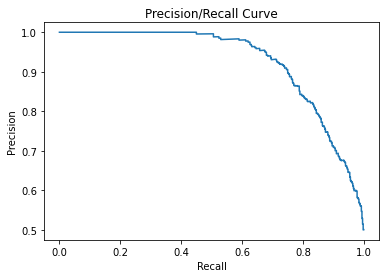

In [7]:
# Plot precision recall curve
y = np.array(claims['label'])
precision, recall, thresh = precision_recall_curve(y, outs)
plt.title('Precision/Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(recall, precision)

<a id='extract'></a>
## Extracting quotes using the model
Now we extract the quotes that have to do with climate change

In [ ]:
# warning might take a while
import glob
files = glob.glob('quotes*')
batch_size = 2000
step_cnt = 0
outs = pd.Series([], dtype='object')
extracted = 0
thresh = 0.1 # Treshold for same precision and recall
with torch.no_grad(): # Turn off gradient computation
    for f in files:
        print('FILE: ' + f)
        quotes = pd.read_json(f, compression='bz2', lines=True)
        quotes.set_index('quoteID', inplace=True)
        cnt = 0
        for i in range(0, len(quotes), batch_size):
            tokens = tokenizer(list(quotes.iloc[i:i + batch_size].quotation),
                               truncation=True, padding=True,
                               max_length=64, return_tensors="pt")
            ids = tokens['input_ids'].to(device)
            mask = tokens['attention_mask'].to(device)
            labels = torch.ones((len(ids),1), dtype=torch.long).to(device)
            out = model(input_ids=ids, attention_mask=mask, labels=labels) # infer
            out = torch.sigmoid(out.logits[:,1])
            out = out.to('cpu').detach().numpy()
            cnt += len(out)
            out_series = pd.Series(data=out, index=quotes.iloc[i:i + batch_size].index)
            out_series = out_series[out_series >= thresh]
            outs = pd.concat([outs, out_series])
            extracted += len(out_series)
            if(step_cnt % 10 == 0):
                print('Progress: ' + str(round(cnt/len(quotes)*100.)) + '%')
                print('Extracted: ' + str(extracted))
            step_cnt += 1

Retrieve the extracted quotes

In [11]:
# concatenate all extracted quotes
extracted_quotes = pd.DataFrame([])
for f in files:
    print('FILE: ' + f)
    quotes = pd.read_json(f, compression='bz2', lines=True)
    quotes.set_index('quoteID', inplace=True)
    shared_ids = quotes.index.isin(outs.index)
    quotes = quotes[shared_ids]
    quotes = quotes.merge(outs.rename('climateChangeProb'), how='left', left_index=True, right_index=True)
    extracted_quotes = pd.concat([extracted_quotes, quotes])
extracted_quotes

FILE: quotes2015_merged_part_1.json.bz2
FILE: quotes2015_merged_part_2.json.bz2
FILE: quotes2016_merged_part_1.json.bz2
FILE: quotes2016_merged_part_2.json.bz2
FILE: quotes2017_merged_part_1.json.bz2
FILE: quotes2017_merged_part_2.json.bz2
FILE: quotes2017_merged_part_3.json.bz2
FILE: quotes2018_merged_part_1.json.bz2
FILE: quotes2018_merged_part_2.json.bz2
FILE: quotes2018_merged_part_3.json.bz2
FILE: quotes2019_merged_part_1.json.bz2
FILE: quotes2019_merged_part_2.json.bz2
FILE: quotes2020_merged_part_1.json.bz2


,quotation,speaker,qids,date,numOccurrences,urls,climateChangeProb
quoteID,,,,,,,
2015-10-21-003064,a remarkable demonstration of chutzpah.,Ben Bernanke,[Q201795],2015-10-21 06:35:00,1,[http://feeds.washingtonpost.com/c/34656/f/636...,0.017989
2015-02-14-014011,I have fought Obamacare from Day One and will ...,John Cornyn,[Q719568],2015-02-14 21:01:51,2,[http://www.politico.com/story/2015/02/sylvia-...,0.018179
2015-11-17-010237,"At the same time, we can't completely abandon ...",Dianne Feinstein,[Q230733],2015-11-17 14:23:00,1,[http://goldrushcam.com/sierrasuntimes/index.p...,0.017977
2015-10-26-009343,"Because America is leading by example, 150 cou...",President Obama,[Q76],2015-10-26 19:52:30,1,[http://catholic.org/news/politics/story.php?i...,0.983340
2015-02-11-008068,"Because domestic energy is more abundant, Amer...",Mark Green,"[Q15739961, Q16224587, Q58037806, Q6767809, Q6...",2015-02-11 18:28:11,1,[http://www.acton.org/pub/commentary/2015/02/1...,0.019651
...,...,...,...,...,...,...,...
2020-04-02-024938,"I think it would be an extreme change,",Jo Ann Davidson,[Q6204111],2020-04-02 14:04:39,2,[http://www.politifact.com/article/2020/apr/02...,0.031958
2020-04-11-013559,I'm talking about telling the fossil fuel indu...,Bernie Sanders,[Q359442],2020-04-11 04:00:00,2,[https://www.commondreams.org/views/2020/04/11...,0.115448
2020-02-03-048133,It's not say we shouldn't recognize white peop...,David Crowley,"[Q28151883, Q5232694]",2020-02-03 14:47:23,11,[https://wislawjournal.com/2020/02/03/wisconsi...,0.017548


Now we save the extracted quotes

In [12]:
extracted_quotes.to_json('climate_change_quotes.json')

<a id='refs'></a>
## References

[1] Varini, Francesco S., et al. “ClimaText: A Dataset for Climate Change Topic Detection.” ArXiv:2012.00483 [Cs], Jan. 2021. arXiv.org, http://arxiv.org/abs/2012.00483.